In [1]:
import numpy as np 
from collections import defaultdict

import time 

import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
class Strategy:
    
    def __init__(self, M, V):
        self.M = M
        self.V = V
        
    def generate_strategy(self, ):
        return np.random.normal(self.M, self.V)
    
    def update_M(self, M):
        self.M = M

class Firm:
    def __init__(
        self, idx=0, explore_capability=0, exploit_capability=0.8, lr_explore=0.1, lr_exploit=0.1, 
        fr_explore=0.02, fr_exploit=0.02, uncertainty=10, M=100, V=25
    ):
        self.idx=idx
        self.explore_capability = explore_capability
        self.exploit_capability = exploit_capability
        
        self.initial_explore_capability = float(self.explore_capability)
        self.initial_exploit_capability = float(self.exploit_capability)
        
        self.lr_explore = lr_explore
        self.lr_exploit = lr_exploit
        self.fr_explore = fr_explore
        self.fr_exploit = fr_exploit
        
        self.strategy_source = Strategy(M, V)
        
        self.uncertainty = uncertainty
        
        self.K = 1
        self.K_max = 5 
        self.W = None
        self.W_max = 25
        
        self.strategy = self.strategy_source.generate_strategy()
        self.perceived_strategy = float(self.strategy)
        
        self.historical_aspiration = 0
        self.social_aspiration = 0
        self.aspiration = 0
        
        self.performance = self.generate_performance()
        
        self.consecutive_success = 0
        self.early_success_tag = -1
    
    def update_capability(self, exploration=False):
        
        if exploration:
            self.explore_capability = self.explore_capability + self.lr_explore * (1-self.explore_capability)
            self.exploit_capability = float(self.initial_exploit_capability)
        else:
            self.explore_capability = self.explore_capability-self.fr_explore * self.explore_capability
            self.exploit_capability = self.exploit_capability + self.lr_exploit * (1-self.exploit_capability)
                        
    def exploration(self, ):
        
        self.W = (1-self.explore_capability) * self.W_max
        self.K = np.round(max(0, self.explore_capability * self.K_max)).astype(np.int32)
        
        for cur in range(self.K):
            
            new_strategy = self.strategy_source.generate_strategy()
            perceived_new_strategy = new_strategy + np.random.normal(0, self.W)
            
            if perceived_new_strategy > self.perceived_strategy:
                self.perceived_strategy = perceived_new_strategy
                self.strategy = new_strategy
        self.update_capability(exploration=True)
        
    def exploitation(self, ):
        self.update_capability(exploration=False)
    
    def generate_performance(self, ):
        return np.random.normal(self.exploit_capability*self.strategy, self.uncertainty/self.exploit_capability)
        
    def calculate_aspiration(self, reference_group_performance, time_stickness=0.5, weight=0.5,):
        
        self.social_aspiration = np.mean(reference_group_performance)
        
        if self.performance > self.social_aspiration:
            self.consecutive_success+=1
        else:
            self.consecutive_success=0
        
        self.historical_aspiration = time_stickness*self.historical_aspiration + (1-time_stickness)*self.performance
        
        self.aspiration = weight * self.social_aspiration + (1-weight) * self.historical_aspiration
        
    def check_early_success(self, step):
        
        if self.early_success_tag==-1 and self.consecutive_success>=5:
            self.early_success_tag = step
        
    def adaptation(self, reference_group_performance, step,):
        
        self.strategy_source.update_M(self.strategy_source.M+2)
        
        self.calculate_aspiration(reference_group_performance)
        self.check_early_success(step)
        
        if self.performance < self.aspiration:
            self.exploration()
            self.performance = self.generate_performance()
            
        else:
            self.exploitation()
            self.performance = self.generate_performance()

In [89]:
def simulation(repeat, agentNum, period, replace=0.02, strategy_momentum=2):
    
    ress_explore = []
    ress_exploit = []
    ress_performance = []
    ress_early_success = []
    
    for r in range(repeat):
        
        print(r, time.asctime())
        
        explore_dic = defaultdict(list)
        exploit_dic = defaultdict(list)
        success_dic = defaultdict(int)
        performance_dic = defaultdict(list)
        
        firms = []
        
        for cur in range(agentNum):
            firm = Firm(cur)
            firms.append(firm)
            
        for step in range(period):
            
            for firm_index, firm in enumerate(firms):
                      
                firm.adaptation([firms[cur].performance for cur in range(agentNum) if cur!=firm_index], step)
            
            performance_cutoff = np.percentile(np.array([firm.performance for firm in firms]), 100*replace)
            
            new_firms = []
            
            for firm in firms:
                if firm.performance>=performance_cutoff:
                    new_firms.append(firm)
                else:
                    new_firms.append(Firm(-1, M=100+2*step))
            
            firms = list(new_firms)
            
            for firm in firms:
                if 0<=firm.idx<agentNum:
                    
                    explore_dic[firm.idx].append(firm.explore_capability)
                    exploit_dic[firm.idx].append(firm.exploit_capability)
                    performance_dic[firm.idx].append(
                        1 if firm.performance > np.mean(
                            [firms[cur].performance for cur in range(agentNum) if cur!=firm_index]) else 0
                    )
                    if firm.early_success_tag!=-1:
                        success_dic[firm.idx]=firm.early_success_tag
                    
        ress_explore.append(explore_dic)
        ress_exploit.append(exploit_dic)
        ress_early_success.append(success_dic)
        ress_performance.append(performance_dic)
    return ress_explore, ress_exploit, ress_early_success, ress_performance

In [106]:
explore, exploit, success, performance = simulation(10, 500, 300)

0 Mon Aug 23 11:10:45 2021
1 Mon Aug 23 11:11:05 2021
2 Mon Aug 23 11:11:26 2021
3 Mon Aug 23 11:11:46 2021
4 Mon Aug 23 11:12:07 2021
5 Mon Aug 23 11:12:27 2021
6 Mon Aug 23 11:12:48 2021
7 Mon Aug 23 11:13:09 2021
8 Mon Aug 23 11:13:30 2021
9 Mon Aug 23 11:13:51 2021


In [118]:
group1 = []
group2 = []
group3 = []

for r in range(10):
    
    inner_success = success[r]
    
    for k in inner_success:
        
        if len(explore[r][k][inner_success[k]-1:inner_success[k]+100])!=101:
            continue
        if 0<=inner_success[k]<20:
            group1.append(explore[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 20<=inner_success[k]<40:
            group2.append(explore[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 40<=inner_success[k]<60:
            group3.append(explore[r][k][inner_success[k]-1:inner_success[k]+100])   

In [119]:
print(len(group1), len(group2), len(group3))

1533 607 179


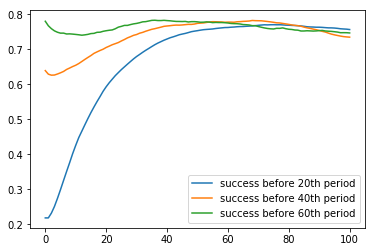

In [122]:
plt.plot(np.mean(np.array(group1), axis=0), label="success before 20th period")
plt.plot(np.mean(np.array(group2), axis=0), label="success before 40th period")
plt.plot(np.mean(np.array(group3), axis=0), label="success before 60th period")
plt.legend()

In [125]:
group1 = []
group2 = []
group3 = []

for r in range(10):
    
    inner_success = success[r]
    
    for k in inner_success:
        
        if len(explore[r][k][inner_success[k]-1:inner_success[k]+100])<101:
            continue
        if 0<=inner_success[k]<20:
            group1.append(performance[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 20<=inner_success[k]<40:
            group2.append(performance[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 40<=inner_success[k]<60:
            group3.append(performance[r][k][inner_success[k]-1:inner_success[k]+100]) 

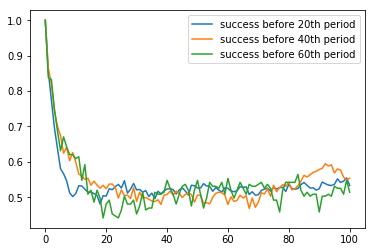

In [126]:
plt.plot(np.mean(np.array(group1), axis=0), label="success before 20th period")
plt.plot(np.mean(np.array(group2), axis=0), label="success before 40th period")
plt.plot(np.mean(np.array(group3), axis=0), label="success before 60th period")
plt.legend()

In [128]:
group1 = []
group2 = []
group3 = []

for r in range(10):
    
    inner_success = success[r]
    
    for k in inner_success:
        
        if len(explore[r][k][inner_success[k]-1:inner_success[k]+100])<101:
            continue
        if 0<=inner_success[k]<20:
            group1.append(exploit[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 20<=inner_success[k]<40:
            group2.append(exploit[r][k][inner_success[k]-1:inner_success[k]+100])
        elif 40<=inner_success[k]<60:
            group3.append(exploit[r][k][inner_success[k]-1:inner_success[k]+100])  